In [6]:
%pylab inline
import scipy.stats

from sigvisa.infer.correlations.ar_correlation_model import ar_advantage, iid_advantage
from sigvisa.signals.xc import my_xc
from sigvisa.signals.io import load_event_station_chan
from sigvisa.models.noise.noise_util import get_noise_model


Populating the interactive namespace from numpy and matplotlib


1240246021.58 1240246231.58
1240241946.92 1240242164.7


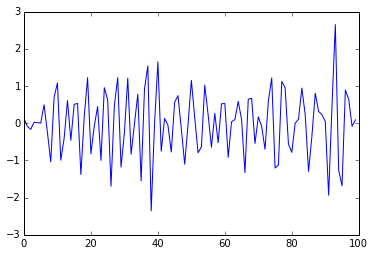

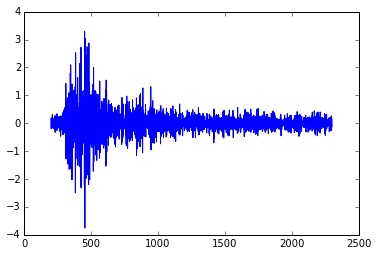

In [7]:
import cPickle as pickle

stas = ['ASAR', 'MKAR', 'CMAR', 'FITZ']

doublet1 = 5334939

doublet2 = 5335822


s1 = load_event_station_chan(doublet1, "MKAR", "auto", evtype="leb").filter("freq_2.0_4.5;hz_10")
s2 = load_event_station_chan(doublet2, "MKAR", "auto", evtype="leb").filter("freq_2.0_4.5;hz_10")

w1 = s2.data[300:400]
w2 = s1.data
plot(w1)
figure()
plot(w2)

307


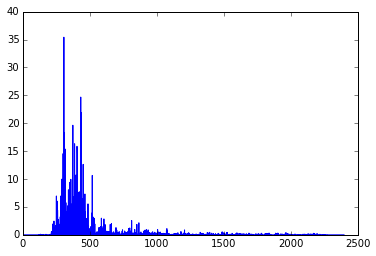

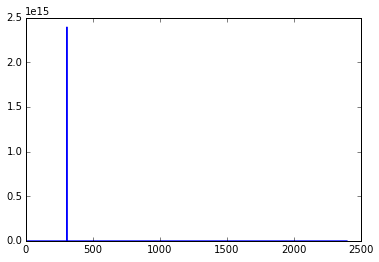

In [39]:
r = iid_advantage(w2, w1)
plot(r)
print np.argmax(r)

expr = np.exp(r)
expr / np.sum(expr)
figure()
plot(expr)

100


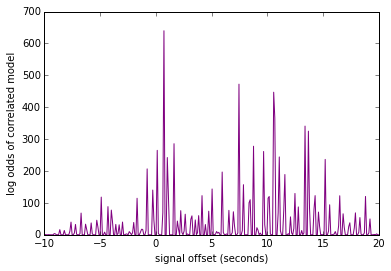

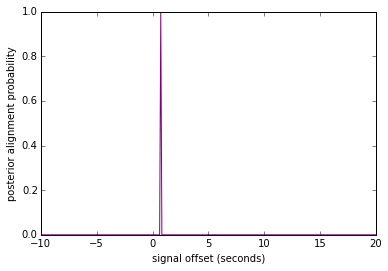

In [72]:
nm, nmid, _ = get_noise_model(waveform=s2, model_type="ar", order=1, return_details=True)
r2 = ar_advantage(w2, w1, nm)
plot(np.linspace(-10, 20, 300), r2[200:500], color="purple")
print np.argmax(r2)
gca().set_xlabel("signal offset (seconds)")
gca().set_ylabel("log odds of correlated model")

expr2 = np.exp(r2 - np.max(np.max(r2[np.isfinite(r2)])))
#expr2 /= np.sum(expr2)
figure()
plot(np.linspace(-10, 20, 300), expr2[200:500], color="purple")
gca().set_xlabel("signal offset (seconds)")
gca().set_ylabel("posterior alignment probability")

# Plotting posterior on event location

In [14]:
%pylab inline
import scipy.stats

from sigvisa.source.event import get_event
from sigvisa.infer.correlations.weighted_event_posterior import ev_time_posterior_with_weight
#import seaborn as sns
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, do_coarse_to_fine, initialize_from, do_inference
import cPickle as pickle

Populating the interactive namespace from numpy and matplotlib


In [101]:


#5336724

#doublet = 5335822
doublet = 5335079



stas = ['ASAR', 'MKAR', 'CMAR', 'FITZ']




rs = EventRunSpec(evids=(doublet,), stas=stas, runids=(1,), disable_conflict_checking=True)
ms = ModelSpec(template_model_type="param", wiggle_family="iid", 
               max_hz=10.0, inference_preset="openworld", raw_signals=True)
sg = rs.build_sg(ms)

ev_doublet = get_event(doublet)


1240250610.34 1240250740.34
1240250985.04 1240251115.04
1240250776.96 1240250906.96
1240250543.22 1240250673.22


In [102]:


#evids = [5334501, 5334726, 5335822, 5349536, 
#         5336237, 5335424, 5349441, 
#         5336889, 5336015]

evids = [5334501, 5334991, 5334726, 5335144, 5349684, 5334939, 5334971, 5349536, 5335116, 5335138, 5350499, 5336237, 5335425, 5335424, 5349441, 5336640, 5335577, 5350077, 5336889, 5335760,\
 5336967, 5337111, 5337461, 5351821, 5351657, 5336724, 5351713, 5338302, 5338318, 5338388, 5335822] 


proposals = []
for evid in evids:
    ev = get_event(evid)
    x = np.array([ev.lon, ev.lat, ev.depth, ev.time, ev.mb]).reshape((1, -1))
    s = load_event_station_chan(evid, "MKAR", "auto", evtype="leb").filter("freq_0.8_4.5;hz_10")
    w = s.data[300:400]
    proposals.append((x, {("MK31", s['chan'], s['band']): w}))



1240230715.08 1240230925.08
1240232513.78 1240232723.78
1240238805.45 1240239015.45
1240239944.45 1240240154.45
1240240870.53 1240241080.53
1240246021.58 1240246231.58
1240247836.82 1240248046.82
1240249697.42 1240249907.42
1240252531.15 1240252741.15
1240253634.25 1240253844.25
1240257000.3 1240257210.3
1240257584.35 1240257794.35
1240264471.95 1240264681.95
1240265159.47 1240265369.47
1240266200.67 1240266410.67
1240270946.53 1240271156.53
1240271119.25 1240271329.25
1240273842.54 1240274052.54
1240276515.05 1240276725.05
1240277341.42 1240277551.42
1240278711.25 1240278921.25
1240282428.0 1240282638.0
1240293355.58 1240293565.58
1240294580.5 1240294790.5
1240295010.1 1240295220.1
1240310899.21 1240311109.21
1240343281.15 1240343491.15
1240373983.89 1240374193.89
1240375306.58 1240375516.58
1240377647.72 1240377857.72
1240241946.92 1240242164.7


In [103]:
global_stime = ev_doublet.time - 50
global_srate = 2.0
N = 200

proposal_otime_likelihoods = [ev_time_posterior_with_weight(sg, x, signals,
                                                                stas=["MK31"],
                                                                N=N, temper=1.0,
                                                                global_stime = global_stime,
                                                                global_srate = global_srate)
                                  for (x, signals) in proposals]
proposal_weights = []
proposal_otime_posteriors = []
for ll in proposal_otime_likelihoods:
    C = np.max(ll)
    posterior = np.exp(ll-C)
    Z = np.sum(posterior)
    posterior /= Z
    logZ = np.log(Z) + C
    proposal_weights.append(logZ)
    proposal_otime_posteriors.append(posterior)

In [104]:
print proposal_weights
proposal_weights = np.array(proposal_weights)
proposal_weights_log = proposal_weights.copy()

proposal_weights /= 10
proposal_weights -= np.max(proposal_weights)
proposal_weights = np.exp(proposal_weights)
proposal_weights += 0.05/len(proposals)
                           # regularize the proposal distribution:
                           # the effect of this is that roughly 5%
                           # of the time we will propose from a
                           # uniform distribution over all
                           # candidates.
proposal_weights /= np.sum(proposal_weights)
print proposal_weights

[1811.1313085093027, 2101.008347379845, 2210.1883256969099, 1772.949492862502, 514.48239148081586, 1966.7114782075998, 501.6776940085976, 427.27873420711239, 1320.8525726808532, 3368.8539131190701, 801.0758326826226, 1485.2502368405815, 1251.341400473759, 1285.3825138302666, 1346.8251316384251, 4129.4571307234719, 1876.236962105073, 1263.4646154692991, 1369.5378101545853, 1897.3032295987994, 1524.0256370405796, 3007.0384230572845, 1734.3487991323709, 442.21393278226799, 1808.6646166265541, 1655.2687677103127, 804.73153756756756, 790.82992422016753, 1258.7125835063821, 1981.3430871564121, 2308.9529274331135]
[ 0.0015361   0.0015361   0.0015361   0.0015361   0.0015361   0.0015361
  0.0015361   0.0015361   0.0015361   0.0015361   0.0015361   0.0015361
  0.0015361   0.0015361   0.0015361   0.95391705  0.0015361   0.0015361
  0.0015361   0.0015361   0.0015361   0.0015361   0.0015361   0.0015361
  0.0015361   0.0015361   0.0015361   0.0015361   0.0015361   0.0015361
  0.0015361 ]


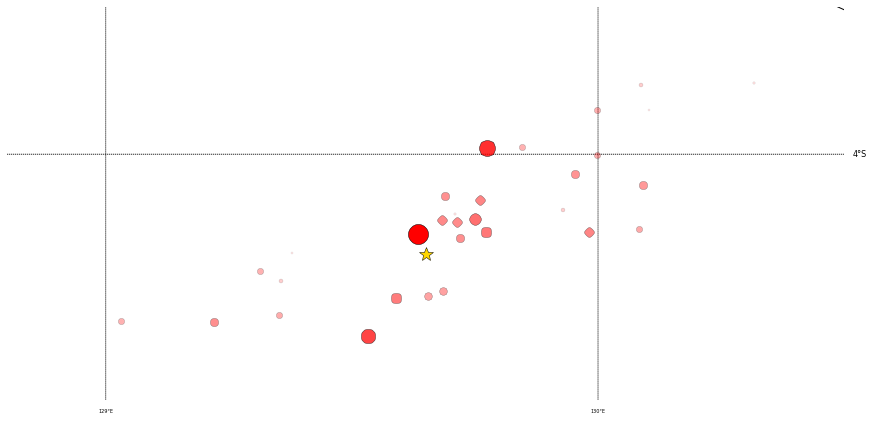

In [111]:

from sigvisa.plotting.event_heatmap import EventHeatmap
from sigvisa.utils.geog import dist_km


hm = EventHeatmap(f=None, left_lon=128.8, right_lon=130.5, bottom_lat=-4.5, top_lat=-3.7, calc=False)

evs = [get_event(evid) for evid in evids]
locs = [(ev.lon, ev.lat) for ev in evs]

#locs_normal = [l for i,l in enumerate(locs) if i+1 != dbl1 and i+1 != dbl1]
#loc1 = locs[dbl1-1:dbl1]
#loc2 = locs[dbl2-1:dbl2]

pwl = proposal_weights_log.copy()
pwl = pwl 

def plot_base():
    f = plt.figure(figsize=(15, 15))
    ax = f.add_subplot(111)
    hm.plot(axes=ax, ev_alpha=1.0, colorseed=1)
    for i, loc in enumerate(locs):
        ms = pwl[i] / np.max(pwl) * 20
        #ms = 12        
        hm.plot_locations([loc], marker="o", ms=ms,  yvals=None, alpha=ms/20.0, mfc="red")
    ax.set_title("")
    ax.axis("off")
    return ax, hm

ax, hm = plot_base()
hm.plot_locations(((ev_doublet.lon, ev_doublet.lat),), marker="*", ms=14,  yvals=None, alpha=1.0, mfc="gold")



In [112]:
print [ev.mb for ev in evs]

[5.0449335, 3.8763521000000001, 3.8056025999999998, 3.9194372, 3.0981019999999999, 4.1739300999999998, 3.1507005000000001, 3.2523818000000002, 3.5623605, 4.1386539000000004, 3.5744633000000001, 4.5433142000000002, 3.9884309999999998, 3.8891018000000002, 3.4794342, 4.6033081999999999, 4.3026403000000002, 3.4324271, 3.5819375, 4.3674472, 4.1909251000000003, 4.0279891000000001, 3.7417332999999999, 3.2962237999999999, 3.7421771000000001, 3.2973865999999998, 2.8962455999999999, 3.4500242999999999, 3.7994368000000001, 3.8847814000000001, 3.9608056]


In [113]:
print evs[0]

evid 5334501.0, loc 129.72 E 4.17 S, depth 0.0km, time 1240230078.4, mb 5.0, natural source
